## 00. PyTorch Classification Exercises

In [1]:
# Import torch
import torch

# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Setup random seed
RANDOM_SEED = 42

device

'cuda'

## 1. Make a binary classification dataset with Scikit-Learn's [`make_moons()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) function.
  * For consistency, the dataset should have 1000 samples and a `random_state=42`.
  * Turn the data into PyTorch tensors.
  * Split the data into training and test sets using `train_test_split` with 80% training and 20% testing.

In [2]:
# Create a dataset with Scikit-Learn's make_moons()
from sklearn.datasets import make_moons

X, y = make_moons(n_samples= 1000,
                  noise=0.07,
                  random_state=RANDOM_SEED)
type(X), type(y),len(X),len(y),X,y[:10]

(numpy.ndarray,
 numpy.ndarray,
 1000,
 1000,
 array([[-0.03341062,  0.4213911 ],
        [ 0.99882703, -0.4428903 ],
        [ 0.88959204, -0.32784256],
        ...,
        [ 1.67125441, -0.32404065],
        [-0.95301576,  0.30220499],
        [ 0.79155232,  0.61130681]]),
 array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0]))

In [3]:
# Turn data into a DataFrame
import pandas as pd
moons = pd.DataFrame({'X1':X[:,0],
                     'X2':X[:,1],
                     'labels':y})
moons.head()

,X1,X2,labels
0,-0.033411,0.421391,1
1,0.998827,-0.442890,1
2,0.889592,-0.327843,1
3,0.341958,-0.417690,1
4,-0.838531,0.532375,0


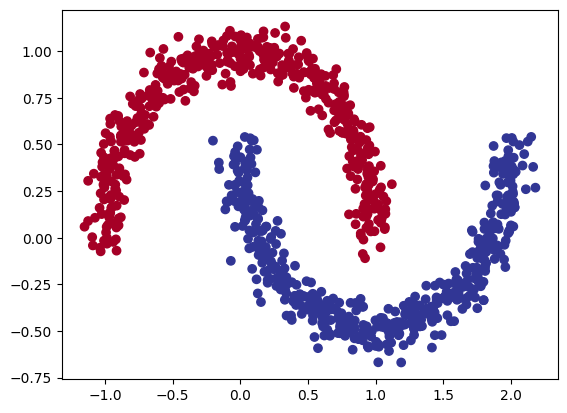

In [4]:
# Visualize the data on a scatter plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],#X轴
            y=X[:,1],#y轴
            c=y,#散点颜色，如上图第一个点(x10,x20)=1，这个点颜色的值为1
            cmap=plt.cm.RdYlBu)

In [5]:
# Turn data into tensors of dtype float
X=torch.from_numpy(X).type(torch.float)
y=torch.from_numpy(y).type(torch.float)

In [6]:
# Split the data into train and test sets (80% train, 20% test)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
len(X_train),len(y_train),len(X_test),len(y_test),y_train.dtype,y_train.shape

(800, 800, 200, 200, torch.float32, torch.Size([800]))

## 2. Build a model by subclassing `nn.Module` that incorporates non-linear activation functions and is capable of fitting the data you created in 1.
  * Feel free to use any combination of PyTorch layers (linear and non-linear)

In [7]:
import torch
from torch import nn

# Inherit from nn.Module to make a model capable of fitting the mooon data
class MoonModelV0(nn.Module):
    ## Your code here ##
    def __init__(self,in_features,out_features,hidden_units):
      super().__init__()
      self.layers = nn.Sequential(
          nn.Linear(in_features=in_features, out_features=hidden_units),
          nn.ReLU(),
          nn.Linear(in_features=hidden_units, out_features=hidden_units),
          nn.ReLU(),
          nn.Linear(in_features=hidden_units, out_features=out_features),
      )

    def forward(self, x):
        ## Your code here ##
        return self.layers(x)

# Instantiate the model
## Your code here ##
model_0 = MoonModelV0(in_features=2, out_features=1, hidden_units=64).to(device)
model_0

MoonModelV0(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [9]:
# model_0.state_dict(),next(model_0.parameters()).shape

## 3. Setup a binary classification compatible loss function and optimizer to use when training the model built in 2.

In [10]:
# Setup loss function
loss_fn = nn.BCEWithLogitsLoss()
# Setup optimizer to optimize model's parameters
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

## 4. Create a training and testing loop to fit the model you created in 2 to the data you created in 1.
  * Do a forward pass of the model to see what's coming out in the form of logits, prediction probabilities and labels.
  * To measure model accuray, you can create your own accuracy function or use the accuracy function in [TorchMetrics](https://torchmetrics.readthedocs.io/en/latest/).
  * Train the model for long enough for it to reach over 96% accuracy.
  * The training loop should output progress every 10 epochs of the model's training and test set loss and accuracy.

In [11]:
# What's coming out of our model?
model_0.eval()
with torch.inference_mode():
  logit = model_0(X_train.to(device))[:10].squeeze()#aaaaaaaaaaasqueeze()
# logits (raw outputs of model)
print("Logits:",logit,logit.shape)

# Prediction probabilities
pred_prob = torch.sigmoid(logit)
print("Pred probs:",pred_prob)

# Prediction labels
pred_label = torch.round(pred_prob)
print("Pred labels:",pred_label)
print(X_train[:5])


Logits: tensor([-0.0132, -0.0263, -0.0063, -0.0080,  0.0566, -0.0058,  0.0666,  0.0319,
        -0.0202, -0.0296], device='cuda:0') torch.Size([10])
Pred probs: tensor([0.4967, 0.4934, 0.4984, 0.4980, 0.5141, 0.4986, 0.5166, 0.5080, 0.4949,
        0.4926], device='cuda:0')
Pred labels: tensor([0., 0., 0., 0., 1., 0., 1., 1., 0., 0.], device='cuda:0')
tensor([[ 2.0144,  0.2466],
        [-1.0187,  0.4045],
        [-0.1252,  1.0580],
        [-0.0977,  0.9901],
        [ 0.3807, -0.2384]])


In [12]:
# Let's calculuate the accuracy using accuracy from TorchMetrics
!pip -q install torchmetrics # Colab doesn't come with torchmetrics
from torchmetrics import Accuracy

## TODO: Uncomment this code to use the Accuracy function
acc_fn = Accuracy(task="multiclass", num_classes=2).to(device) # send accuracy function to device
acc_fn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 7.4 MB/s eta 0:00:00


MulticlassAccuracy()

In [13]:
torch.manual_seed(RANDOM_SEED)

# Setup epochs
epochs = 1000

# Send data to the device
X_train=X_train.to(device)
X_test=X_test.to(device)
y_train=y_train.to(device)
y_test=y_test.to(device)

# Loop through the data
for epoch in range(epochs):
  ### Training
  model_0.train()

  # 1. Forward pass (logits output)
  logits = model_0(X_train).squeeze()

  # Turn logits into prediction probabilities
  pred_probs = torch.sigmoid(logits)

  # Turn prediction probabilities into prediction labels
  pred_labels = torch.round(pred_probs)

  # 2. Calculaute the loss
  # loss = loss_fn(y_logits, y_train) # loss = compare model raw outputs to desired model outputs
  loss = loss_fn(logits, y_train)

  # Calculate the accuracy
  # acc = acc_fn(y_pred, y_train.int()) # the accuracy function needs to compare pred labels (not logits) with actual labels
  acc = acc_fn(pred_labels, y_train.int())
  # 3. Zero the gradients
  optimizer.zero_grad()

  # 4. Loss backward (perform backpropagation)
  loss.backward()

  # 5. Step the optimizer (gradient descent)
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass (to get the logits)
    test_logits = model_0(X_test).squeeze()

    # Turn the test logits into prediction labels
    test_pred_labels = torch.round(torch.sigmoid(test_logits))

    # 2. Caculate the test loss/acc
    test_loss = loss_fn(test_logits, y_test)
    test_acc = acc_fn(test_pred_labels, y_test.int())


  # Print out what's happening every 100 epochs
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.2f} Acc: {acc:.2f} | Test loss: {test_loss:.2f} | Test Acc: {test_acc:.2f}")

Epoch: 0 | Loss: 0.68 Acc: 0.83 | Test loss: 0.67 | Test Acc: 0.83
Epoch: 100 | Loss: 0.25 Acc: 0.88 | Test loss: 0.25 | Test Acc: 0.89
Epoch: 200 | Loss: 0.19 Acc: 0.92 | Test loss: 0.18 | Test Acc: 0.93
Epoch: 300 | Loss: 0.13 Acc: 0.95 | Test loss: 0.12 | Test Acc: 0.96
Epoch: 400 | Loss: 0.08 Acc: 0.98 | Test loss: 0.07 | Test Acc: 0.99
Epoch: 500 | Loss: 0.05 Acc: 0.99 | Test loss: 0.04 | Test Acc: 1.00
Epoch: 600 | Loss: 0.03 Acc: 1.00 | Test loss: 0.03 | Test Acc: 1.00
Epoch: 700 | Loss: 0.02 Acc: 1.00 | Test loss: 0.02 | Test Acc: 1.00
Epoch: 800 | Loss: 0.02 Acc: 1.00 | Test loss: 0.01 | Test Acc: 1.00
Epoch: 900 | Loss: 0.01 Acc: 1.00 | Test loss: 0.01 | Test Acc: 1.00


## 5. Make predictions with your trained model and plot them using the `plot_decision_boundary()` function created in this notebook.

In [14]:
# Plot the model predictions
import numpy as np

def plot_decision_boundary(model, X, y):

    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Source - https://madewithml.com/courses/foundations/neural-networks/
    # (with modifications)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

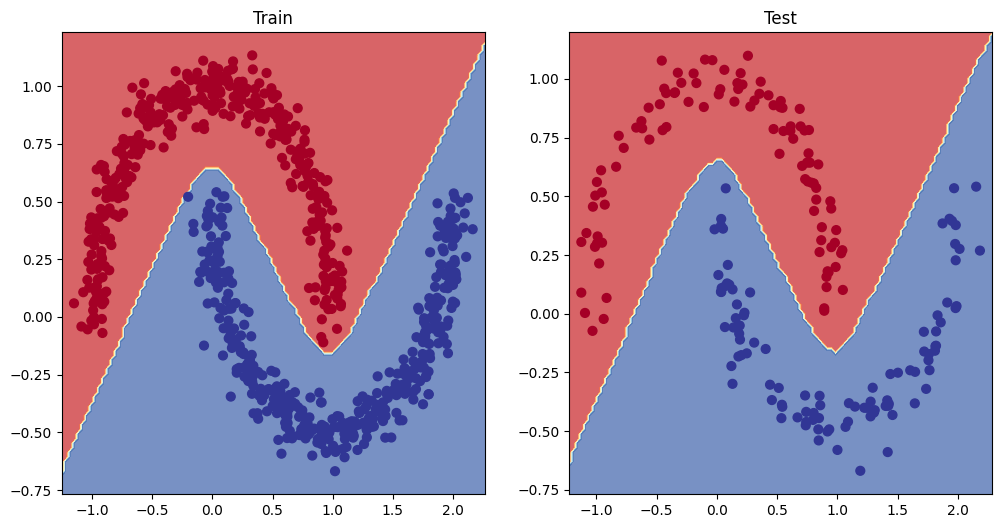

In [15]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)#一共一行两列，在第一个
plt.title('Train')
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)#一共一行两列，在第一个
plt.title('Test')
plot_decision_boundary(model_0, X_test, y_test)

## 6. Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch.
  * Feel free to reference the [ML cheatsheet website](https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#tanh) for the formula.

In [16]:
# Create a straight line tensor
x = torch.arange(-100,100,1)
y_straight = 0.7 * x + 0.3
x,x.shape,y_straight

(tensor([-100,  -99,  -98,  -97,  -96,  -95,  -94,  -93,  -92,  -91,  -90,  -89,
          -88,  -87,  -86,  -85,  -84,  -83,  -82,  -81,  -80,  -79,  -78,  -77,
          -76,  -75,  -74,  -73,  -72,  -71,  -70,  -69,  -68,  -67,  -66,  -65,
          -64,  -63,  -62,  -61,  -60,  -59,  -58,  -57,  -56,  -55,  -54,  -53,
          -52,  -51,  -50,  -49,  -48,  -47,  -46,  -45,  -44,  -43,  -42,  -41,
          -40,  -39,  -38,  -37,  -36,  -35,  -34,  -33,  -32,  -31,  -30,  -29,
          -28,  -27,  -26,  -25,  -24,  -23,  -22,  -21,  -20,  -19,  -18,  -17,
          -16,  -15,  -14,  -13,  -12,  -11,  -10,   -9,   -8,   -7,   -6,   -5,
           -4,   -3,   -2,   -1,    0,    1,    2,    3,    4,    5,    6,    7,
            8,    9,   10,   11,   12,   13,   14,   15,   16,   17,   18,   19,
           20,   21,   22,   23,   24,   25,   26,   27,   28,   29,   30,   31,
           32,   33,   34,   35,   36,   37,   38,   39,   40,   41,   42,   43,
           44,   45,   46,  

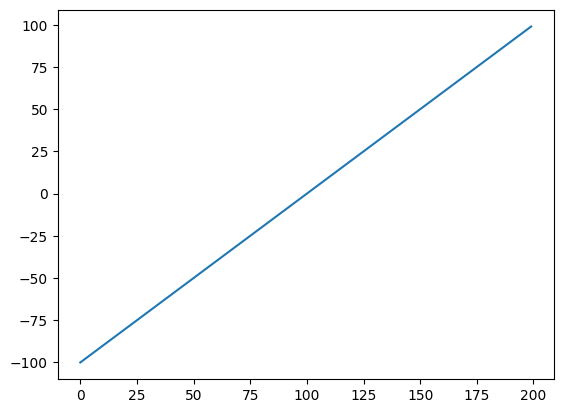

In [17]:
plt.plot(x);
#如果只传入一个参数，则x轴显示(start=0,end=N,step=1),传入的参数则对应在y轴，如下，x中的第一个数1在y轴，x轴对应0

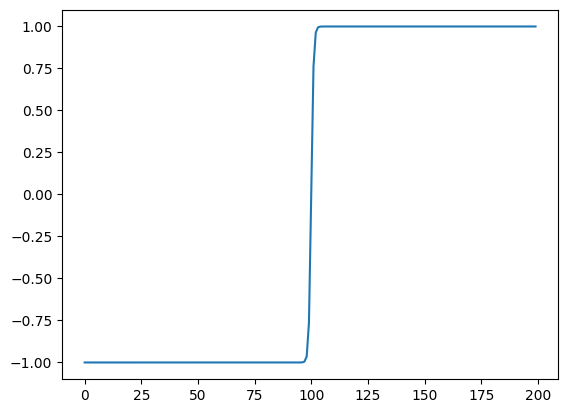

In [18]:
# Test torch.tanh() on the tensor and plot it
plt.plot(torch.tanh(x))

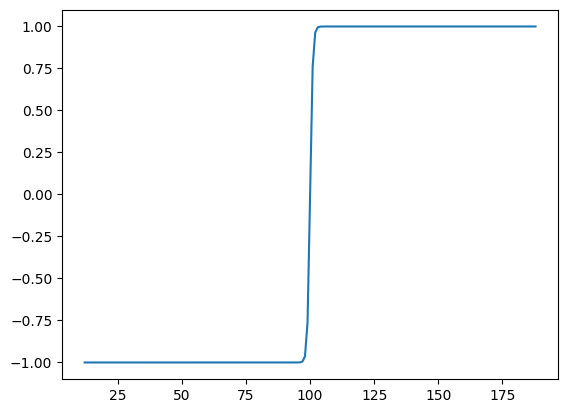

In [19]:
# Replicate torch.tanh() and plot it
def tanh(x):
  return (torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))

plt.plot(tanh(x))

## 7. Create a multi-class dataset using the [spirals data creation function from CS231n](https://cs231n.github.io/neural-networks-case-study/) (see below for the code).
  * Split the data into training and test sets (80% train, 20% test) as well as turn it into PyTorch tensors.
  * Construct a model capable of fitting the data (you may need a combination of linear and non-linear layers).
  * Build a loss function and optimizer capable of handling multi-class data (optional extension: use the Adam optimizer instead of SGD, you may have to experiment with different values of the learning rate to get it working).
  * Make a training and testing loop for the multi-class data and train a model on it to reach over 95% testing accuracy (you can use any accuracy measuring function here that you like) - 1000 epochs should be plenty.
  * Plot the decision boundaries on the spirals dataset from your model predictions, the `plot_decision_boundary()` function should work for this dataset too.

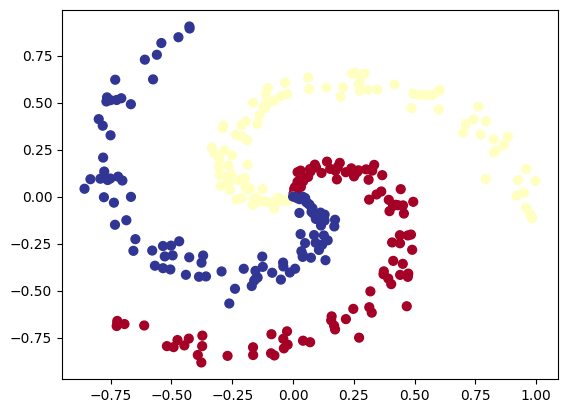

In [20]:
# Code for creating a spiral dataset from CS231n
import numpy as np
import matplotlib.pyplot as plt
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.show()

In [21]:
X.dtype,y.dtype,X.shape,y.shape

(dtype('float64'), dtype('uint8'), (300, 2), (300,))

In [22]:
# Turn data into tensors
import torch
X = torch.from_numpy(X).type(torch.float) # features as float32
y = torch.from_numpy(y).type(torch.LongTensor) # labels need to be of type long

# Create train and test splits
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=RANDOM_SEED)
print(f"len X_train:{len(X_train)}|len X_test:{len(X_test)}|len y_train:{len(y_train)}|len y_test:{len(y_test)}")

len X_train:240|len X_test:60|len y_train:240|len y_test:60


In [23]:
torch.unique(y_train)

tensor([0, 1, 2])

In [24]:
y_test

tensor([2, 2, 1, 0, 2, 2, 1, 1, 0, 1, 2, 0, 2, 0, 1, 2, 2, 2, 1, 1, 0, 1, 2, 2,
        1, 0, 2, 2, 1, 2, 0, 1, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2,
        1, 2, 1, 1, 2, 0, 2, 2, 0, 0, 1, 0])

In [25]:
# Let's calculuate the accuracy for when we fit our model
!pip -q install torchmetrics # colab doesn't come with torchmetrics
from torchmetrics import Accuracy

acc_fn = Accuracy(task="multiclass", num_classes=4).to(device)
acc_fn

MulticlassAccuracy()

In [26]:
# Prepare device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

# Create model by subclassing nn.Module
class MultiClassModelV0(nn.Module):
  def __init__(self,in_features,out_features,hidden_units):
    super().__init__()

    self.layers = nn.Sequential(
      nn.Linear(in_features,hidden_units),
      nn.ReLU(),
      nn.Linear(hidden_units,hidden_units),
      nn.ReLU(),
      nn.Linear(hidden_units,hidden_units),
      )

  def forward(self,x):
    return self.layers(x)


# Instantiate model and send it to device
model_1 = MultiClassModelV0(2,3,64).to(device)
model_1

MultiClassModelV0(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
  )
)

In [28]:
# model_1.state_dict()

In [30]:
# Setup data to be device agnostic
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

# Print out first 10 untrained model outputs (forward pass)
model_1.eval()
with torch.inference_mode():
  logit = model_1(X_train)
# print("Logits:",logit[:10])

#softmax 将数据压缩到(0,1)区间，且和为1(!) dim=0表示按列计算；dim=1表示按行计算
#sigmoid 将一个实数映射到(0,1)的区间
pred_prob = torch.softmax(logit, dim=1)
# print("Pred probs:",pred_prob[:10])

#argmax dim=0 按列找这一列最大值，下标从0往下，dim=1 按行找最大值，下标从0往右
pred_label = torch.argmax(pred_prob, dim=1)
# print("Pred labels:",pred_label[:10])
## Your code here ##

In [31]:
c = torch.tensor([[2,3,4,5],[1,2,3,4]])
c.shape

torch.Size([2, 4])

In [32]:
c.argmax(dim=1)

tensor([3, 3])

In [33]:
# Setup loss function and optimizer
#CrossEntropyLoss(input:float,target:torch.long) long dtype in cpu/gpu is torch.LongTensor
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr = 0.01)

In [34]:
# Build a training loop for the model
epochs = 1000
# Loop over data

for epoch in range(epochs):
  ## Training
  model_1.train()

  # 1. Forward pass
  logits = model_1(X_train).squeeze()
  pred_prods = torch.softmax(logits,dim=1)
  pred_labels = pred_prods.argmax(dim=1)

  # 2. Calculate the loss
  loss = loss_fn(logits, y_train)
  acc = acc_fn(y_train, pred_labels)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ## Testing
  model_1.eval()
  with torch.inference_mode():

    # 1. Forward pass
    test_logits = model_1(X_test).squeeze()
    test_pred_labels = torch.softmax(test_logits,dim=1).argmax(dim=1)

    # 2. Caculate loss and acc
    test_loss = loss_fn(test_logits, y_test)
    test_acc = acc_fn(y_test, test_pred_labels)

  # Print out what's happening every 100 epochs
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f} | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}")

Epoch: 0 | Loss: 4.22611, Acc: 0.00 | Test Loss: 3.99651, Test Acc: 0.32
Epoch: 100 | Loss: 0.07385, Acc: 0.99 | Test Loss: 0.04482, Test Acc: 1.00
Epoch: 200 | Loss: 0.03353, Acc: 0.99 | Test Loss: 0.00754, Test Acc: 1.00
Epoch: 300 | Loss: 0.02467, Acc: 0.99 | Test Loss: 0.00195, Test Acc: 1.00
Epoch: 400 | Loss: 0.02049, Acc: 0.99 | Test Loss: 0.00062, Test Acc: 1.00
Epoch: 500 | Loss: 0.01815, Acc: 0.99 | Test Loss: 0.00024, Test Acc: 1.00
Epoch: 600 | Loss: 0.01677, Acc: 0.99 | Test Loss: 0.00012, Test Acc: 1.00
Epoch: 700 | Loss: 0.01590, Acc: 0.99 | Test Loss: 0.00007, Test Acc: 1.00
Epoch: 800 | Loss: 0.01532, Acc: 0.99 | Test Loss: 0.00007, Test Acc: 1.00
Epoch: 900 | Loss: 0.01493, Acc: 0.99 | Test Loss: 0.00006, Test Acc: 1.00


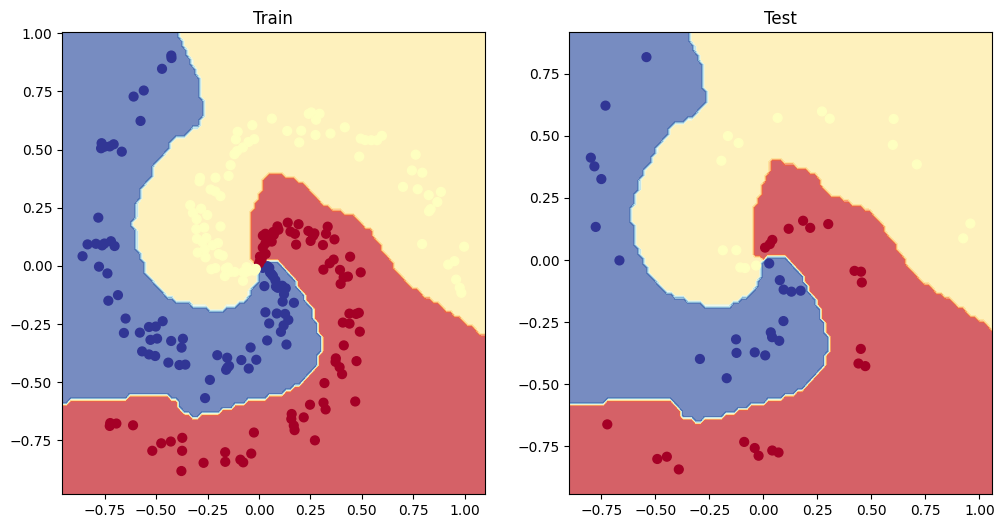

In [35]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_1, X_test, y_test)
